In [1]:
from collections import Counter
import numpy as np
import os
import pandas as pd

import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


2023-12-12 07:31:49.396069: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-12 07:31:49.397609: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-12 07:31:49.418224: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 07:31:49.418249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 07:31:49.418927: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
print(sklearn.__version__)
print(tf.__version__)

1.3.2
2.15.0


In [3]:
# Settings cell

# %%
# Can save Densenet models fine tuned with different labels
# melanocytic (2 classes)
# THE_MODEL = "fine_tuned_model_melanocytic.keras"
# label = "melanocytic"

# diagnosis (8 classes)
THE_MODEL = "fine_tuned_model.keras"
label = "diagnosis"

# benign_malignant (2 classes)
# THE_MODEL = "fine_tuned_model_bm.keras"
# label = "benign_malignant"


metadata_path = "/uw/ml_unsuper/ISIC_proc/data/ham10000_metadata_2023-11-27.csv"
# The minimum number of images with a label required to include a label in the dataset
minimum_count = 10
augment_training_data = False
augment_test_data = False
force_load_model = False
force_load_preds = True
EPOCHS = 10


In [4]:
data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.9, 1.1],
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest",
)


In [5]:
def image_generator(
    image_directory,
    filtered_metadata,
    label_encoder,
    additional_augmentations,
    batch_size=32,
    num_classes=8,
    augment_data=False,
    label="diagnosis",
    filter=True,
):
    num_samples = len(filtered_metadata)
    augmented_images_counter = {label: 0 for label in additional_augmentations.keys()}

    while True:  # Generator loops indefinitely
        for offset in range(0, num_samples, batch_size):
            batch_samples = filtered_metadata.iloc[offset : offset + batch_size]

            images = []
            labels = []
            for ix, row in batch_samples.iterrows():
                if filter is True and pd.isna(row[label]):
                    continue

                img_path = os.path.join(image_directory, row["isic_id"] + ".JPG")
                try:
                    img = image.load_img(img_path, target_size=(224, 224))
                    img = image.img_to_array(img)
                    img = K.applications.densenet.preprocess_input(img)

                    # Apply LabelEncoder to get the encoded label
                    encoded_label = label_encoder.transform([row[label]])[0]

                    # Check if augmentation is needed for this label
                    if augment_data and augmented_images_counter[row[label]] < additional_augmentations[row[label]]:
                        augmented_img = img.reshape((1,) + img.shape)  # Reshape for data_gen
                        augmentations_to_do = additional_augmentations[row[label]] - augmented_images_counter[row[label]]
                        for _ in range(augmentations_to_do):
                            augmented_image = data_gen.flow(augmented_img, batch_size=1).next()[0]
                            images.append(augmented_image)
                            labels.append(encoded_label)
                            augmented_images_counter[row[label]] += 1
                            if augmented_images_counter[row[label]] >= additional_augmentations[row[label]]:
                                break

                    # Append the original image and its label
                    images.append(img)
                    labels.append(encoded_label)
                except Exception as e:
                    print(f"Error processing file {img_path}: {e}")
                    continue

            if images:
                X_batch = np.array(images)
                Y_batch = K.utils.to_categorical(labels, num_classes=num_classes)
                yield X_batch, Y_batch


In [6]:
def get_fine_tuned_DenseNet(
    input_tensor,
    num_classes=8,
):
    print("Getting finetuned DenseNet")
    UNFREEZE_LAYER = -30

    # Step 1 load model
    base_model = tf.keras.applications.DenseNet201(
        include_top=False, weights="imagenet", input_tensor=input_tensor
    )

    # Step 2 add Custom layers
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)

    predictions = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    # Step 3 Compile Model
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    # Step 4 Optional Initail Training
    # Step 5 Freeze Layers and set trainable
    unfreeze_layer = UNFREEZE_LAYER
    for layer in model.layers[:unfreeze_layer]:
        layer.trainable = False
    for layer in model.layers[unfreeze_layer:]:
        layer.trainable = True

    # Step 6 Compile Model again
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Step 7, Fine tuning done at the return
    return model


In [7]:
def get_densenet_num_classes():
    assert model, "Model not found"
    output_layer = model.layers[-1]
    output_shape = output_layer.output_shape
    num_classes = output_shape[-1]  # Assuming the output layer is a Dense layer
    print(f"Number of classes in the output layer: {num_classes}")
    return num_classes


In [8]:
def get_metadata(
    image_directory,
    metadata_path,
    label_column,
    minimum_count=10,
    filter_images=True,
    min_count_threshold=0.25,
):
    # Load and preprocess metadata
    metadata = pd.read_csv(metadata_path)
    # if not filter_images:
    # diagnosis_counts = metadata[label_column].value_counts(dropna=False)
    # else:
    diagnosis_counts = metadata[label_column].value_counts()

    # Filter metadata
    if filter_images:
        filtered_metadata = metadata[
            metadata[label_column].isin(
                diagnosis_counts[diagnosis_counts >= minimum_count].index
            )
        ]
    else:
        filtered_metadata = metadata

    # Fit the LabelEncoder on the filtered labels
    label_encoder = LabelEncoder()
    if not filter_images:
        label_encoder.fit(filtered_metadata[label_column])
    else:
        label_encoder.fit(filtered_metadata[label_column].dropna())
    num_classes = len(label_encoder.classes_)

    return filtered_metadata, label_encoder, num_classes


In [9]:
def view_data(y1, preds, mapping, quiet=False):
    # Initialize dictionaries to store the results
    cluster_stats = {}
    totals = {key: 0 for key in range(8)}
    max_values = {key: {"label": None, "value": 0} for key in range(8)}

    for val in set(y1):
        inds = [i for i in range(len(y1)) if y1[i] == val]
        p = preds[inds]
        y2 = y1[inds]
        counts = dict(Counter(p))

        # sort counts by key
        counts = dict(sorted(counts.items()))

        # Store the counts in the cluster_stats dictionary
        cluster_stats[val] = counts

        # Calculate totals and update max_values for each key (cluster)
        for key, value in counts.items():
            totals[key] += value
            if value > max_values[key]["value"]:
                max_values[key] = {"label": key, "value": value}
        if not quiet:
            print("Cluster:", val)
            print("Counts:", counts)
            # Max value and label
            print("Max value:", max(counts.values()))
            max_label = max(counts, key=counts.get)
            print("Max label:", max_label, mapping[max_label])
            percentage = (max(counts.values()) / sum(counts.values())) * 100
            percentage = round(percentage, 2)
            print(f"{percentage}% exclusive")
            # Total count
            print("Total count:", sum(counts.values()))
            print("----------------")

    if not quiet:
        # After processing all clusters, print the aggregated statistics
        print("Total Counts for Each Cluster:", totals)
        print("Maximum Value and Label for Each Cluster:", max_values)

    return cluster_stats, totals, max_values


In [10]:
def is_standard_python() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return False   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        # Probably a standard Python interpreter
        return True


In [11]:
def view_results(y_data, pred_data, kmeans, label_encoder, quiet=False):
    labels_true = np.argmax(y_data, axis=1)
    preds = kmeans.predict(pred_data)
    num_classes = len(y_data[0])

    decoded_labels = label_encoder.inverse_transform(preds)
    if not quiet:
        print(set(decoded_labels))

    mapping = {}
    reverse_mapping = {}

    for d, p in zip(decoded_labels, preds):
        mapping[d] = p
        reverse_mapping[p] = d



    cluster_stats, totals, max_values = view_data(labels_true, preds, reverse_mapping, quiet)

    return cluster_stats, totals, max_values, reverse_mapping


In [12]:
if __name__ == "__main__" and is_standard_python():
    d = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
    data_dir = os.path.join(d, "data")
else:
    data_dir = "../data"

image_directory = os.path.join(data_dir, "images")

num_classes_path = os.path.join(data_dir, "num_classes.npy")
save_preds_train = os.path.join(data_dir, "preds_train.npy")
save_preds_test = os.path.join(data_dir, "preds_test.npy")

save_true_Ytrain = os.path.join(data_dir, "true_Ytrain.npy")
save_true_Ytest = os.path.join(data_dir, "true_Ytest.npy")

MODEL_NAME = os.path.join(data_dir, THE_MODEL)

local_save_paths = [num_classes_path, save_preds_train, save_preds_test,
                    save_true_Ytrain, save_true_Ytest, MODEL_NAME]


assert os.path.exists(data_dir), "Data directory not found"
assert os.path.exists(image_directory), "Image directory not found"
assert os.path.exists(metadata_path), "Metadata file not found"


In [13]:
def calculate_augmentations(filtered_metadata, label_column, min_count_threshold=0.25, empty=False):
    """
    Calculate the number of additional images needed for each label in a dataset.

    Parameters:
        filtered_metadata (pandas.DataFrame): The filtered metadata containing the image labels. The applied
            filters may include a minimum number of labels and exclusion of NaN labels.
        label_column (str): The name of the column in the metadata that contains the image labels.
        min_count_threshold (float, optional): The minimum count threshold as a fraction of the maximum count.
            Default is 0.25.

    Returns:
        dict: A dictionary where the keys are the labels and the values are the number of additional images
            needed for each label.
    """
    if empty:
        return {label: 0 for label in filtered_metadata[label_column].unique()}
    label_counts = filtered_metadata[label_column].value_counts()
    max_count = max(label_counts)
    minimum_count = round(max_count * min_count_threshold)

    additional_images_needed = {
        label: max(0, minimum_count - count) for label, count in label_counts.items()
    }
    return additional_images_needed


In [14]:
def predict_generator(model, metadata, x_generator, batch_size=32):
    num_samples = len(metadata)
    predict_steps = np.ceil(num_samples / batch_size)

    predictions = []
    true_labels = []
    for _ in range(int(predict_steps)):
        print(f"Predicting batch {_:+3}/{predict_steps:+3}...", end="\r")
        X_batch, Y_batch = next(x_generator)  # Get both features and labels from the same generator

        batch_predictions = model.predict(X_batch)
        predictions.extend(batch_predictions)
        true_labels.extend(Y_batch)  # Assuming Y_batch is not one-hot encoded; if it is, convert it back

    return np.array(predictions), np.array(true_labels)


In [15]:
filtered_metadata, label_encoder, num_classes = get_metadata(
    image_directory, metadata_path, label, minimum_count=minimum_count
)

# Assuming filtered_metadata is already prepared
train_metadata, test_metadata = train_test_split(
    filtered_metadata, test_size=0.4, random_state=42
)
# Calculate additional augmentations needed
# label_column = "melanocytic"
train_augments = calculate_augmentations(train_metadata, label)
test_augments = calculate_augmentations(test_metadata, label)

train_generator = image_generator(
    image_directory,
    train_metadata,
    label_encoder,
    train_augments,
    batch_size=32,
    num_classes=num_classes,
    augment_data=False,
    label=label,
)
test_generator = image_generator(
    image_directory,
    test_metadata,
    label_encoder,
    test_augments,
    batch_size=32,
    num_classes=num_classes,
    augment_data=False,
    label=label,
)


In [16]:
if not os.path.exists(MODEL_NAME) or force_load_model is True:
    print("Fine tuning the model. This will take a while. Please wait.")
    print("Loading training data for DenseNet")

    print("Fine-tuning DenseNet ...")
    input_tensor = K.Input(shape=(224, 224, 3))
    model = get_fine_tuned_DenseNet(input_tensor, num_classes=num_classes)

    print("Training pre-trained model")
    model.fit(
        train_generator,
        epochs=EPOCHS,
        steps_per_epoch=len(train_metadata) // 32,
    )
    model.save(MODEL_NAME)  # Use model.save instead of np.save for models

else:
    print("Loading pre-trained model from local storage")
    model = load_model(MODEL_NAME)

model.summary()


Loading pre-trained model from local storage


2023-12-12 07:31:51.009162: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-12 07:31:51.011939: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [17]:
if not os.path.isfile(save_preds_train) or force_load_preds == True:


    # preds_train, true_Ytrain = predict_generator(model, train_metadata, train_generator)
    preds_test, true_Ytest = predict_generator(model, test_metadata, test_generator)


    # np.save(save_preds_train, preds_train)
    np.save(save_preds_test, preds_test)

    # np.save(save_true_Ytrain, true_Ytrain)
    np.save(save_true_Ytest, true_Ytest)
else:
    print("Loading precomputed predictions")

    preds_train = np.load(save_preds_train)
    preds_test = np.load(save_preds_test)

    true_Ytrain = np.load(save_true_Ytrain)
    true_Ytest = np.load(save_true_Ytest)


1/1 [==============================] - 2s 2s/step


In [18]:
sklearn.__version__

'1.3.2'

In [19]:
kmeans_test = KMeans(
    n_clusters=num_classes,
    random_state=22,
    max_iter=1000,
    algorithm="lloyd",
    tol=0.000001,
).fit(preds_test)

def runKmeans(preds):
    kmeans = KMeans(
        n_init=10,
        n_clusters=num_classes,
        # random_state=22,
        max_iter=20000,
        algorithm="lloyd",
        tol=0.000001,
        verbose=0
    ).fit(preds)
    return kmeans

/uw/.venvs/ml_research/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [20]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


def evaluate_clusters(labels_true, labels_pred):
    """
    Evaluates the clustering performance based on true labels.

    Args:
    labels_true: array-like, true class labels
    labels_pred: array-like, predicted cluster labels

    Returns:
    A dictionary containing ARI, NMI, and purity scores.
    """

    # Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(labels_true, labels_pred)

    # Normalized Mutual Information (NMI)
    nmi = normalized_mutual_info_score(labels_true, labels_pred, average_method='arithmetic')

    # Purity
    # Create a contingency matrix
    contingency_matrix = pd.crosstab(labels_true, labels_pred)

    # Normalize the contingency matrix
    # contingency_matrix = contingency_matrix / np.sum(contingency_matrix, axis=1)

    # Calculate purity
    purity = np.max(contingency_matrix, axis=1) / np.sum(contingency_matrix, axis=1)
    purity0 = np.max(contingency_matrix, axis=0) / np.sum(contingency_matrix, axis=0)

    return {"ARI": ari, "NMI": nmi, "Purity": purity,"Purity0": purity0, "Contingency": contingency_matrix}


In [21]:
# Assuming kmeans is already fitted to preds_X
labels_pred = kmeans_test.predict(preds_test)

# Convert one-hot encoded labels to single labels if necessary
if true_Ytest.shape[1] > 1:  # Checking if true_Y is one-hot encoded
    labels_true = np.argmax(true_Ytest, axis=1)
else:
    labels_true = true_Ytest

print(label)
# Evaluate clusters
evaluation_results = evaluate_clusters(labels_true, labels_pred)
print("Evaluation Results:", evaluation_results)


cluster_stats, totals, max_values, reverse_mapping = view_results(true_Ytest, preds_test, kmeans_test, label_encoder)


diagnosis
Evaluation Results: {'ARI': 0.6635938245678014, 'NMI': 0.44384748393679824, 'Purity': row_0
0    0.483333
1    0.679842
2    0.467742
3    0.582061
4    0.906027
5    0.649091
6    0.435897
7    0.773333
dtype: float64, 'Purity0': col_0
0    0.925215
1    0.488038
2    0.635417
3    0.751092
4    0.892308
5    0.709742
6    0.298969
7    0.409639
dtype: float64, 'Contingency': col_0     0    1    2    3   4    5   6   7
row_0                                      
0         0    1    3    4   0   12  29  11
1        21   13   10  172   3   21   6   7
2        13    3    0    5   0    6  29   6
3       113   47  305    6   0   34   8  11
4      2796  102   99   18   3   59   5   4
5        67   38   53    9   1  357  15  10
6         5    4    7   12   0   11   5  34
7         7    1    3    3  58    3   0   0}
{'pigmented benign keratosis', 'squamous cell carcinoma', 'actinic keratosis', 'dermatofibroma', 'melanoma', 'vascular lesion', 'nevus', 'basal cell carcinoma'}
Cluster:

In [22]:
def eval_all(kmeans, preds, y_data, label_encoder, quiet=True):

    # Assuming kmeans is already fitted to preds_X
    labels_pred = kmeans.predict(preds)

    # Convert one-hot encoded labels to single labels if necessary
    if true_Ytest.shape[1] > 1:  # Checking if true_Y is one-hot encoded
        labels_true = np.argmax(y_data, axis=1)
    else:
        labels_true = y_data

    if not quiet:
        print(label)
    # Evaluate clusters
    evaluation_results = evaluate_clusters(labels_true, labels_pred)


    cluster_stats, totals, max_values, reverse_mapping = view_results(y_data, preds, kmeans, label_encoder, quiet=quiet)
    return cluster_stats, totals, max_values, reverse_mapping, evaluation_results


In [23]:
def clustered_together(cm, reverse_mapping):
    clustermax = {}
    for m in reverse_mapping:
        ix_max = [(i, x) for i, x in enumerate(cm[m]) if x == max(cm[m])]
        if clustermax.get(ix_max[0][0]) is None:
            clustermax[ix_max[0][0]] = [reverse_mapping[m]]
        else:
            clustermax[ix_max[0][0]].append(reverse_mapping[m])

    # filter out values of length  1
    x = {k: v for k, v in clustermax.items() if len(v) > 1}
    return x


    if x:
        print("The following max diagnoses were clustered together:")
        print(x)
        return x
    else:
        print("No max diagnoses were clustered together.")
        return []

        


In [24]:
# from sklearn.cluster import KMeans
kmeansarr = []
kmeansevals = []
for _ in range(100):
    kmeansarr.append(runKmeans(preds_test))
    cstats, tots, maxv, rmap, evalr = eval_all(kmeansarr[-1], preds_test, true_Ytest, label_encoder)
    kmeansevals.append({
        'cluster_stats': cstats,
        'totals': tots,
        'max_values': maxv,
        'reverse_mapping': rmap,
        'evaluation_results': evalr
    })


In [25]:
purity0sum = [sum(x['evaluation_results']['Purity0']) for x in kmeansevals]
puritysum = [sum(x['evaluation_results']['Purity']) for x in kmeansevals]
# get row index of max puritysum
maxpurityindex = puritysum.index(max(puritysum))
maxpurity0index = purity0sum.index(max(purity0sum))

minpurityindex = puritysum.index(min(puritysum))
minpurity0index = purity0sum.index(min(purity0sum))


if max(puritysum) > max(purity0sum):
    max_ix = maxpurityindex
    print('Contingency matrix axis 1 got better results')
else:
    max_ix = maxpurity0index
    print('Contingency matrix axis 0 got better results')

if min(puritysum) < min(purity0sum):
    min_ix = minpurityindex
    print('Contingency matrix axis 1 got worse results')
else:
    min_ix = minpurity0index
    print('Contingency matrix axis 0 got worse results')
max_ix = max(maxpurityindex, maxpurity0index)
print(kmeansevals[max_ix]['evaluation_results'])
print(sum(kmeansevals[max_ix]['evaluation_results']['Purity0']))
print("minvalue:")
print(sum(kmeansevals[minpurity0index]['evaluation_results']['Purity0']))


Contingency matrix axis 0 got better results
Contingency matrix axis 1 got worse results
{'ARI': 0.6692806058953018, 'NMI': 0.4623288273543444, 'Purity': row_0
0    0.500000
1    0.683794
2    0.451613
3    0.612595
4    0.932923
5    0.663636
6    0.448718
7    0.773333
dtype: float64, 'Purity0': col_0
0    0.907057
1    0.708738
2    0.633136
3    0.748918
4    0.402299
5    0.852941
6    0.508475
7    0.595745
dtype: float64, 'Contingency': col_0     0    1    2    3   4   5   6   7
row_0                                     
0         0   12    2    4  11   0  30   1
1        31   21   10  173   7   4   4   3
2        16    6    0    5   6   0   1  28
3       141   34  321    6  11   0   7   4
4      2879   63  108   19   6   4   1   6
5        91  365   56    9  11   2  11   5
6         8   11    7   12  35   0   5   0
7         8    3    3    3   0  58   0   0}
5.357308332732297
minvalue:
5.110418605965534


In [30]:
bestContingency = kmeansevals[max_ix]['evaluation_results']['Contingency']


max_indices = np.argmax(bestContingency.values, axis=0)
# Count how often each index appears as a maximum
index_counts = pd.Series(max_indices).value_counts()

# Sort the contingency matrix by these counts
sorted_matrix = bestContingency.iloc[index_counts.index]


col_0,0,1,2,3,4,5,6,7
row_0,,,,,,,,
4,104,59,101,18,2792,3,4,5
5,37,357,54,9,67,1,10,15
3,46,34,306,6,113,0,11,8
1,13,21,10,175,21,1,7,5
7,2,3,3,4,6,57,0,0
6,4,11,7,12,5,0,34,5
0,1,12,3,4,0,0,11,29


In [45]:

worstContingency = kmeansevals[min_ix]['evaluation_results']['Contingency']
max_indices2 = np.argmax(worstContingency.values, axis=0)

# hack_indices
max_indices2[0] = 2
index_counts2 = pd.Series(max_indices2).value_counts()

duplicates = index_counts2.index[index_counts2 > 1]

# Hack the order to display the worst contingency matrix



# Sort the contingency matrix by these counts
sorted_matrix_worst = worstContingency.iloc[index_counts2.index]
sorted_matrix_worst










col_0,0,1,2,3,4,5,6,7
row_0,,,,,,,,
2,3,6,0,5,13,0,6,29
5,37,357,54,9,67,1,10,15
3,46,34,306,6,113,0,11,8
1,13,21,10,175,21,1,7,5
4,104,59,101,18,2792,3,4,5
7,2,3,3,4,6,57,0,0
6,4,11,7,12,5,0,34,5
0,1,12,3,4,0,0,11,29


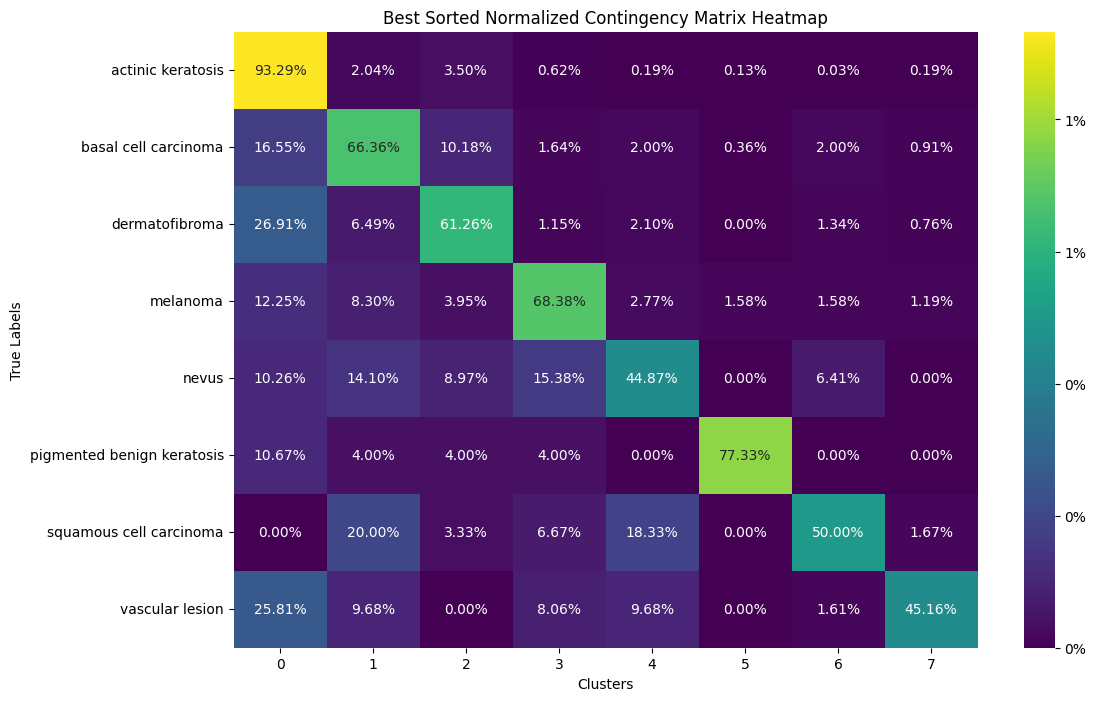

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

def display_results(contingency_matrix, label_encoder, title, normalize='index'):
    # Normalize the contingency matrix
    if normalize == 'index':  # Normalize by row
        normalized_matrix = contingency_matrix.div(contingency_matrix.sum(axis=1), axis=0)
    elif normalize == 'columns':  # Normalize by column
        normalized_matrix = contingency_matrix.div(contingency_matrix.sum(axis=0), axis=0)
    else:
        normalized_matrix = contingency_matrix  # No normalization




    # Rename row indices to match label names
    normalized_matrix.index = label_encoder.classes_

    plt.figure(figsize=(12, 8))
    sns.heatmap(normalized_matrix, annot=True, cmap='viridis', fmt='.2%', cbar_kws={'format': '%.0f%%'})
    
    plt.title(title)
    plt.ylabel('True Labels')
    plt.xlabel('Clusters')
    plt.savefig('contingency.png')
    plt.show()
    # save the figure
    plt.close()

# Example usage
# Use your existing contingency matrix and label_encoder
display_results(sorted_matrix, label_encoder, 'Best Sorted Normalized Contingency Matrix Heatmap')


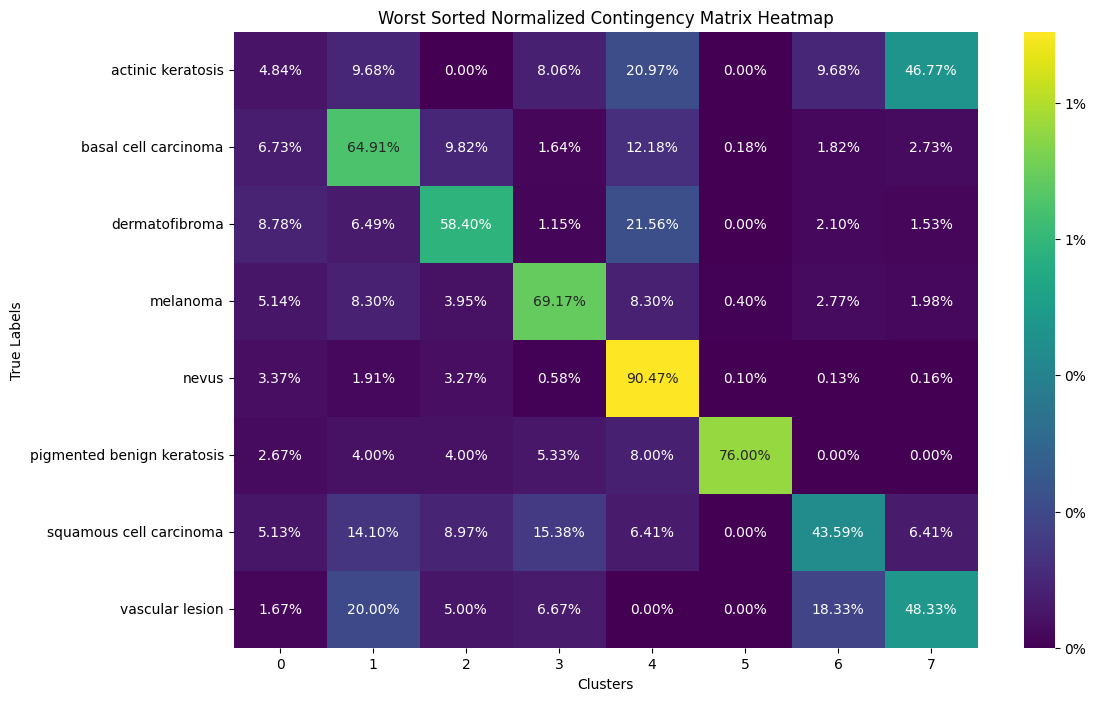

In [47]:
display_results(sorted_matrix_worst, label_encoder, 'Worst Sorted Normalized Contingency Matrix Heatmap')

In [ ]:

display_results(sorted_matrix)

In [ ]:
lab=4
i = 0
truPositive = bestContingency[i][lab]
falsePositive = sum(bestContingency.T[lab]) - truPositive
truPositive, falsePositive

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt


In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(labels_true, labels_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)
# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming preds_test is your data and num_classes is the number of clusters you want
# First, reduce the data dimensions with PCA to 3 for a 3D scatter plot
def plot_clusters(index):
    pca = PCA(n_components=3)
    reduced_data_3d = pca.fit_transform(preds_test)

    # Perform KMeans clustering
    # kmeans = KMeans(n_clusters=num_classes, random_state=22)
    kmeans = kmeansarr[index]
    kmeans.fit(preds_test)

    # Predict the cluster labels
    cluster_labels = kmeans.predict(preds_test)

    # Plotting each sample in the reduced 3D space, colored by cluster label
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(reduced_data_3d[:, 0], reduced_data_3d[:, 1], reduced_data_3d[:, 2],
                        c=cluster_labels, cmap='viridis', marker='o')

    # Optionally, plot the cluster centers in the reduced 3D space
    centers_reduced_3d = pca.transform(kmeans.cluster_centers_)
    ax.scatter(centers_reduced_3d[:, 0], centers_reduced_3d[:, 1], centers_reduced_3d[:, 2],
            c='red', s=200, alpha=0.75, marker='x')

    # Create color bar and labels
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Cluster Label')

    ax.set_title('3D Visualization of KMeans Clustering')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')

    plt.show()

plot_clusters(max_ix)

In [ ]:
plot_clusters(minpurity0index)

In [ ]:
from scipy.cluster.hierarchy import linkage
cluster_centers = kmeansarr[max_ix].cluster_centers_
hierarchical_clusters = linkage(cluster_centers, method='ward')
dendrogram(hierarchical_clusters)
plt.title('Dendogram for KMeans Clustering')
plt.xlabel('Cluster')
plt.ylabel('Distance')
plt.show()

In [ ]:

eval_all(kmeansarr[max_ix], preds_test, true_Ytest, label_encoder, quiet=False)
clustered_together(kmeansevals[max_ix]['evaluation_results']['Contingency'], kmeansevals[max_ix]['reverse_mapping'])

In [ ]:
cluster_pair_counts = {}
for i, eval in enumerate(kmeansevals):
    clustered = clustered_together(eval['evaluation_results']['Contingency'], eval['reverse_mapping'])
    if clustered:
        keys = [":".join(x) for x in list(clustered.values())]
        for k in keys:
            if cluster_pair_counts.get(k) is None:
                cluster_pair_counts[k] = 1
            else:
                cluster_pair_counts[k] += 1 
    
    
    
print(cluster_pair_counts)

In [ ]:

eval_all(kmeansarr[maxpurityindex], preds_test, true_Ytest, label_encoder, quiet=False)
clustered_together(kmeansevals[maxpurityindex]['evaluation_results']['Contingency'], kmeansevals[maxpurityindex]['reverse_mapping'])

In [ ]:
def clear_local_saved_data():
    for r in local_save_paths:
        if os.path.isfile(r):
            try:
                os.remove(r)
                print(f"Removed {r}")
            except OSError:
                print(f"Failed to remove {r}")
        else:
            print(f"{r} does not exist.")
    return
    


# ask user if they want to remove the data
remove_data = input("Do you want to remove the data? (y/n): ")
if remove_data.lower() == "y":
    clear_local_saved_data()


In [ ]:
kmeansarr = []
kmeansarr.append(kmeans_test)
for _ in range(20):